# Audio Decoder in DALI

This tutorial presents, how to set up simple pipeline, that loads and decodes audio data in DALI. Here we will use simple example from Speech Commands Data Set. While this dataset consists of samples in .wav format, following procudure can be used for most of the well-known formats for audio decoding.

## Step-by-step guide
1. Let's start by importing handful of utils and DALI itself.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 1
audio_files = "audio"

used `batch_size` is `1`, to keep things simple.

2. Next, let's implement the pipeline. Firstly, you need to load data from disk (or any other place). Used FileReader is able to load data, as well as it's labels. For more information, refer to FileReader docs. Furthermore, similarly to image data, you can use Reader ops specific for given dataset or dataset format (see [CaffeReader](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.CaffeReader)). After loading input, pipeline decodes the AudioData. As stated above, the AudioDecoder operator is able to decode most on well-known audio formats.
   
   Note: Please remember, that you shall pass proper `dtype` argument to the operator. Supported types can be found in the documentation. If you have 24-bit audio data and you set `dtype=INT16`, it will result in loosing some information from the samples.

In [2]:
class AudioDecoderCpuExample(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(AudioDecoderCpuExample, self).__init__(batch_size, num_threads, device_id)
        self.input = ops.FileReader(device="cpu", file_root=audio_files)
        self.decode = ops.AudioDecoder(device="cpu")

    def define_graph(self):                                                                
        read, _ = self.input()
        audio = self.decode(read)
        return audio

3. Now let's just build and run the pipeline.

In [3]:
pipecpu = AudioDecoderCpuExample(batch_size=batch_size, num_threads=1, device_id=0)
pipecpu.build()          
cpu_output = pipecpu.run()

Outputs from `AudioDecoder` consist of a tensor with decoded data, as well as metadata (e.g. sampling rate). To access them just check another output. Here's how to use it:

Sampling rate: 16000 [Hz]


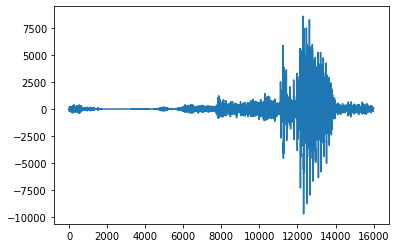

In [4]:
audio_data = cpu_output[0].at(0)
sampling_rate = cpu_output[1].at(0)[0]
print("Sampling rate:", sampling_rate, "[Hz]")
plt.plot(audio_data[0])
plt.show()

## Verification

Let's verify, that the AudioDecoder actually works. The presented method can also come in handy for debugging DALI pipeline, in case something doesn't go as planned. 

We will use external tool to decode used data and compare the results against data decoded by DALI.

### Important!

Following snippet installs the external dependency (`simpleaudio`). In case you already have it, or don't want to install it, you might want to stop here and not run this one.

In [ ]:
import sys
!{sys.executable} -m pip install simpleaudio

Below is the side-by-side comparision of decoded data. If you have the `simpleaudio` module installed, you can run the snippet and see it for yourself.

In [ ]:
import simpleaudio as sa
import numpy as np

wav = sa.WaveObject.from_wave_file("audio/wav/three.wav")
three_audio = np.frombuffer(wav.audio_data, dtype=np.int16)

print("src: simpleaudio")
print("shape: ", three_audio.shape)
print("data: ", three_audio)
print("\n")
print("src: DALI")
print("shape: ", audio_data[0].shape)
print("data: ", audio_data[0])

fig, ax = plt.subplots(1,2)
ax[0].plot(three_audio)
ax[1].plot(audio_data[0])
plt.show()